In [153]:
# ------ START OF COMMON FILE ANALYSIS CODE -----
# Dependencies
import pandas as pd
from pathlib import Path
import scipy.stats as st
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from datetime import datetime

In [154]:
# --- Set filepath for file to analyze ---
# NOTE: Edit this for each new file being run
zillow_csv_path = Path('Zillow_Data/Metro_market_temp_index_uc_sfrcondo_month.csv')
zillow_metric_name = 'Market Heat Index'

In [277]:
# --- Create a data frame containing the data from the CSV ---
# Load the CSV
zillow_df = pd.read_csv(zillow_csv_path)
# Insert 'US' as the state name for the United States region, so it shows up in state summary
zillow_df.at[0,"StateName"] = 'US'
# Rename labels
zillow_df.rename(columns={'SizeRank': 'Size Rank', 'RegionName': 'Metro Area', 'StateName': 'State' }, inplace=True)
# Remove the RegionType column
zillow_df = zillow_df.drop('RegionType', axis = 1)
# Insert a new blank column to store the Size Segment
zillow_df['Size Segment'] = pd.NA
# Re-order columns so that Size Segment is next to Size Rank
columns = zillow_df.columns.tolist()
columns.remove('Size Segment')
columns.insert(2, 'Size Segment')
zillow_df = zillow_df[columns]
# Establish Size Segments as bins
size_segment_bins = [-1, 0, 100, 200, 300, 400, 500, 1000]
size_segment_labels = ["National Average", "Top 100", "101 - 200", "201 - 300", "301 - 400", "401 - 500", "Bottom 500"]
# Insert segment values into Size Segment column
zillow_df['Size Segment'] = pd.cut(zillow_df["Size Rank"], bins=size_segment_bins, labels=size_segment_labels)
# Select only the columns with date information and the 'Size Segment' column
date_columns = [col for col in zillow_df.columns if isinstance(col, str) and col.startswith('2018') or col.startswith('2019') or col.startswith('2020') or col.startswith('2021') or col.startswith('2022') or col.startswith('2023')]
columns_of_interest = ['RegionID', 'Size Rank', 'Size Segment', 'Metro Area', 'State'] + date_columns
zillow_df= zillow_df[columns_of_interest]

# Create a unique data frame which is named after the metric currently being analyzed:
# Set the df name as a string equal to the zillow metric name, with spaces replaced with underscores and in all lowercase
zillow_unique_df_name = zillow_metric_name.replace(" ", "_").lower() + "_df"
globals()[zillow_unique_df_name] = zillow_df.copy()
print(f'Created new dataframe: {zillow_unique_df_name}')

Created new dataframe: market_heat_index_df


In [281]:
# --- Create a data frame segmented by state ---
# Create a data frame that summarizes the data by size segment
state_summary_df = zillow_df.groupby('State').mean('State').drop('RegionID',  axis = 1).drop('Size Rank',  axis = 1)
state_summary_df.reset_index(inplace=True)
state_summary_df.rename(columns={'State': 'Date'}, inplace = True)
state_summary_df.set_index('Date', inplace=True)
state_summary_df = state_summary_df.T
state_summary_df.reset_index(inplace=True)
state_summary_df.rename(columns={'index': 'Date'}, inplace=True)
state_summary_df['Date'] = pd.to_datetime(state_summary_df['Date'])
# Copy to uniquely named data frame
state_unique_df_name = zillow_metric_name.replace(" ", "_").lower() + "_df_state"
globals()[state_unique_df_name] = state_summary_df.copy()
print(f'Created new dataframe: {state_unique_df_name}')

Created new dataframe: market_heat_index_df_state


In [280]:
# --- Create a data frame segmented by size rank ---
# Group by 'Size Segment' and calculate the mean for each segment
zillow_df_mean = zillow_df.groupby('Size Segment', observed = False).mean('Size Segment').drop('RegionID',  axis = 1).drop('Size Rank',  axis = 1)
# Reset the index for better display
zillow_df_mean.reset_index(inplace=True)
zillow_df_mean.rename(columns={'Size Segment': 'Date'}, inplace = True)
zillow_df_mean.set_index('Date', inplace=True)
zillow_df_mean = zillow_df_mean.T
zillow_df_mean.reset_index(inplace=True)
zillow_df_mean.rename(columns={'index': 'Date'}, inplace=True)
zillow_df_mean['Date'] = pd.to_datetime(zillow_df_mean['Date'])
# Create uniquely named data frame
size_unique_df_name = zillow_metric_name.replace(" ", "_").lower() + "_df_size"
globals()[size_unique_df_name] = zillow_df_mean.copy()
print(f'Created new dataframe: {size_unique_df_name }')

Created new dataframe: market_heat_index_df_size


In [284]:
interest_rates_csv_path = Path('Zillow_Data/fed-funds-rate-historical-chart-modified.csv')
interest_rates_df = pd.read_csv(interest_rates_csv_path)
interest_rates_df['Date'] = pd.to_datetime(interest_rates_df['Date'])
interest_rates_df

,Date,Federal Funds Rate
0,1954-07-01,1.13
1,1954-07-02,1.25
2,1954-07-03,1.25
3,1954-07-04,1.25
4,1954-07-05,0.88
...,...,...
24914,2024-08-24,NaN
24915,2024-08-25,NaN
24916,2024-08-26,NaN
24917,2024-08-27,NaN


In [309]:
market_heat_index_vs_interest_rate_df = pd.merge(market_heat_index_df_size, interest_rates_df, on="Date", how='inner')
market_heat_index_vs_interest_rate_df

,Date,National Average,Top 100,101 - 200,201 - 300,301 - 400,401 - 500,Bottom 500,Federal Funds Rate
0,2018-01-31,49.0,51.010101,40.050505,34.102041,24.357143,22.237113,25.770026,1.34
1,2018-02-28,50.0,50.878788,41.262626,36.234694,26.969388,24.536082,26.951482,1.35
2,2018-03-31,52.0,54.424242,44.525253,40.867347,33.381443,28.947917,31.173442,1.67
3,2018-04-30,54.0,58.101010,47.404040,43.561224,36.581633,32.804124,34.952000,1.69
4,2018-05-31,54.0,58.545455,47.858586,44.816327,38.010309,34.250000,36.379581,1.70
5,2018-07-31,52.0,52.414141,43.888889,42.214286,36.153061,33.896907,35.182990,1.91
6,2018-08-31,50.0,50.252525,41.969697,39.448980,33.540816,31.042105,32.287206,1.91
7,2018-10-31,47.0,45.323232,38.010101,34.765306,27.410526,25.042105,27.764398,2.20
8,2018-11-30,47.0,45.212121,37.555556,33.969388,24.887755,24.216495,26.753181,2.20
9,2018-12-31,49.0,48.707071,40.535354,36.948980,27.969388,27.020833,28.529563,2.40


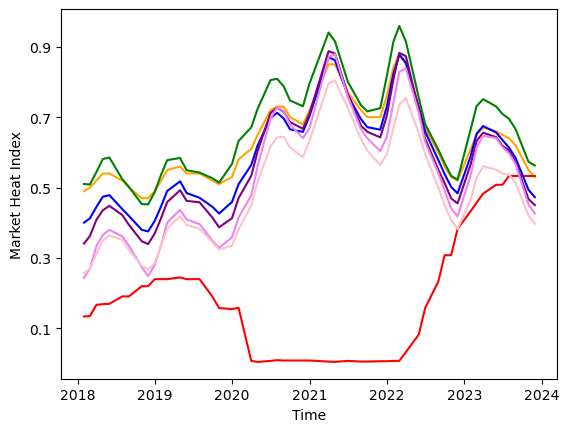

In [317]:
plt.plot(market_heat_index_vs_interest_rate_df['Date'], market_heat_index_vs_interest_rate_df['National Average']/100, label = "National Average", color = "orange")
plt.plot(market_heat_index_vs_interest_rate_df['Date'], market_heat_index_vs_interest_rate_df['Federal Funds Rate']/10, label = "Federal Funds Rate", color  = "red")
plt.plot(market_heat_index_vs_interest_rate_df['Date'], market_heat_index_vs_interest_rate_df['Top 100']/100, label = "Top 100", color = "green")
plt.plot(market_heat_index_vs_interest_rate_df['Date'], market_heat_index_vs_interest_rate_df['101 - 200']/100, label = "101 - 200", color = "blue")
plt.plot(market_heat_index_vs_interest_rate_df['Date'], market_heat_index_vs_interest_rate_df['201 - 300']/100, label = "201 - 300", color = "purple")
plt.plot(market_heat_index_vs_interest_rate_df['Date'], market_heat_index_vs_interest_rate_df['301 - 400']/100, label = "301 - 400", color = "violet")
plt.plot(market_heat_index_vs_interest_rate_df['Date'], market_heat_index_vs_interest_rate_df['Bottom 500']/100, label = "Bottom 500", color = "pink")
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xlabel("Time")
plt.ylabel("Market Heat Index")
plt.yticks([0.10, 0.30, 0.50, 0.70, 0.90])
plt.show()

In [287]:
corr_market_heat_national_interest_rates = market_heat_index_vs_interest_rate_df['National Average'].corr(market_heat_index_vs_interest_rate_df['Federal Funds Rate'])
corr_market_heat_national_interest_rates

-0.4705110111382041

In [296]:
start_date = '2018-01-01'
end_date = '2019-12-31'
market_heat_index_vs_interest_rate_df_prepandemic = market_heat_index_vs_interest_rate_df[(market_heat_index_vs_interest_rate_df['Date'] >= start_date) & (market_heat_index_vs_interest_rate_df['Date'] <= end_date)]
corr_market_heat_national_interest_rates_prepandemic = market_heat_index_vs_interest_rate_df_prepandemic['National Average'].corr(market_heat_index_vs_interest_rate_df_prepandemic['Federal Funds Rate'])
corr_market_heat_national_interest_rates_prepandemic

0.19680219566569057

In [298]:
start_date = '2020-01-01'
end_date = '2021-12-31'
market_heat_index_vs_interest_rate_df_pandemic = market_heat_index_vs_interest_rate_df[(market_heat_index_vs_interest_rate_df['Date'] >= start_date) & (market_heat_index_vs_interest_rate_df['Date'] <= end_date)]
corr_market_heat_national_interest_rates_pandemic = market_heat_index_vs_interest_rate_df_pandemic['National Average'].corr(market_heat_index_vs_interest_rate_df_pandemic['Federal Funds Rate'])
corr_market_heat_national_interest_rates_pandemic

-0.5177291319538373

In [300]:
start_date = '2022-01-01'
end_date = '2023-12-31'
market_heat_index_vs_interest_rate_df_postpandemic = market_heat_index_vs_interest_rate_df[(market_heat_index_vs_interest_rate_df['Date'] >= start_date) & (market_heat_index_vs_interest_rate_df['Date'] <= end_date)]
corr_market_heat_national_interest_rates_postpandemic = market_heat_index_vs_interest_rate_df_postpandemic['National Average'].corr(market_heat_index_vs_interest_rate_df_postpandemic['Federal Funds Rate'])
corr_market_heat_national_interest_rates_postpandemic

-0.718422452822994

In [320]:
state_market_index_vs_interest_rate_df = pd.merge(market_heat_index_df_state, interest_rates_df, on="Date", how='inner')
state_market_index_vs_interest_rate_df

,Date,AK,AL,AR,AZ,CA,CO,CT,DE,FL,...,TX,US,UT,VA,VT,WA,WI,WV,WY,Federal Funds Rate
0,2018-01-31,62.250000,28.857143,29.941176,35.909091,54.676471,48.058824,40.4,42.5,36.000000,...,38.968254,49.0,55.555556,32.071429,17.25,56.450000,44.000000,-6.250000,30.777778,1.34
1,2018-02-28,57.750000,30.100000,32.266667,36.727273,53.030303,52.764706,43.0,42.5,34.517241,...,39.354839,50.0,56.750000,32.785714,19.75,58.000000,48.652174,-5.142857,32.444444,1.35
2,2018-03-31,49.500000,33.400000,35.066667,40.181818,54.205882,56.176471,47.2,44.5,36.285714,...,42.409836,52.0,56.111111,34.714286,22.50,62.750000,55.652174,2.875000,36.500000,1.67
3,2018-04-30,44.500000,35.473684,39.875000,43.363636,56.787879,55.470588,47.8,46.0,40.172414,...,45.015873,54.0,56.777778,36.214286,23.25,66.700000,58.304348,4.428571,39.500000,1.69
4,2018-05-31,50.750000,35.400000,41.687500,44.181818,57.333333,54.529412,48.0,46.5,41.896552,...,46.854839,54.0,57.777778,36.428571,25.25,65.900000,58.695652,6.714286,40.222222,1.70
5,2018-07-31,47.750000,35.400000,38.600000,41.454545,50.484848,52.294118,46.0,46.5,42.655172,...,44.774194,52.0,55.444444,37.142857,30.00,56.550000,56.347826,8.875000,40.250000,1.91
6,2018-08-31,39.750000,36.000000,39.187500,42.363636,48.121212,49.470588,44.6,47.0,40.931034,...,44.016393,50.0,53.111111,36.714286,25.75,53.500000,50.521739,4.571429,36.250000,1.91
7,2018-10-31,48.500000,31.761905,29.500000,41.272727,43.764706,44.411765,41.4,46.0,34.034483,...,40.333333,47.0,48.666667,34.500000,16.50,46.500000,37.217391,-2.285714,35.222222,2.20
8,2018-11-30,49.250000,29.000000,30.500000,38.909091,43.696970,42.294118,41.2,45.0,33.551724,...,40.359375,47.0,49.000000,33.785714,14.50,47.700000,35.434783,0.250000,33.000000,2.20
9,2018-12-31,44.250000,31.000000,34.000000,40.454545,47.090909,43.562500,44.4,45.5,35.413793,...,41.906250,49.0,50.000000,36.714286,17.00,52.550000,41.772727,3.750000,34.555556,2.40


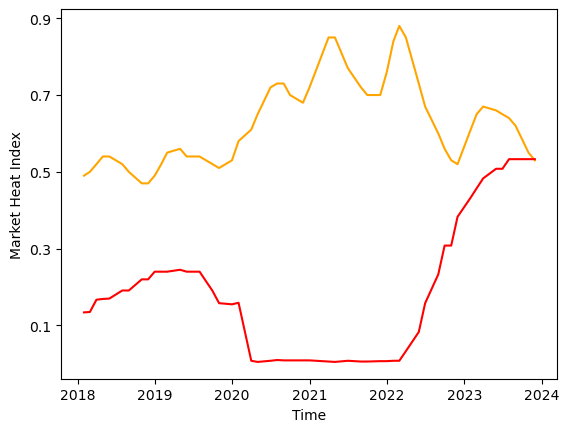

In [327]:
plt.plot(state_market_index_vs_interest_rate_df['Date'], state_market_index_vs_interest_rate_df['US']/100, label = "National Average", color = "orange")
plt.plot(market_heat_index_vs_interest_rate_df['Date'], market_heat_index_vs_interest_rate_df['Federal Funds Rate']/10, label = "Federal Funds Rate", color  = "red")
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xlabel("Time")
plt.ylabel("Market Heat Index")
plt.yticks([0.10, 0.30, 0.50, 0.70, 0.90])
plt.show()